In [1]:
import os
import gc
import numpy as np
import pandas as pd
from scipy.stats import kurtosis
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
import xgboost as xgb
from xgboost import XGBClassifier
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
DATA_DIRECTORY = "../input/home-credit-default-risk"

In [3]:
df_train = pd.read_csv(os.path.join(DATA_DIRECTORY, 'application_train.csv'))
df_test = pd.read_csv(os.path.join(DATA_DIRECTORY, 'application_test.csv'))
df = df_train.append(df_test)
del df_train, df_test; gc.collect()

0

In [4]:
df = df[df['AMT_INCOME_TOTAL'] < 20000000]
df = df[df['CODE_GENDER'] != 'XNA']
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
df['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)

In [5]:
def get_age_group(days_birth):
    age_years = -days_birth / 365
    if age_years < 27: return 1
    elif age_years < 40: return 2
    elif age_years < 50: return 3
    elif age_years < 65: return 4
    elif age_years < 99: return 5
    else: return 0

In [6]:
docs = [f for f in df.columns if 'FLAG_DOC' in f]
df['DOCUMENT_COUNT'] = df[docs].sum(axis=1)
df['NEW_DOC_KURT'] = df[docs].kurtosis(axis=1)
df['AGE_RANGE'] = df['DAYS_BIRTH'].apply(lambda x: get_age_group(x))

In [7]:
df['EXT_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
df['EXT_SOURCES_WEIGHTED'] = df.EXT_SOURCE_1 * 2 + df.EXT_SOURCE_2 * 1 + df.EXT_SOURCE_3 * 3
np.warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
    feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
    df[feature_name] = eval('np.{}'.format(function_name))(
        df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

In [8]:
df['CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
df['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
df['ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
df['INCOME_TO_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']
df['INCOME_TO_BIRTH_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']    
df['EMPLOYED_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['ID_TO_BIRTH_RATIO'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH']
df['CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
df['CAR_TO_EMPLOYED_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
df['PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']

In [9]:
def do_mean(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].mean().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df

In [10]:
def do_median(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].median().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df

In [11]:
def do_std(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].std().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df

In [12]:
def do_sum(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].sum().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df

In [13]:
group = ['ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'AGE_RANGE', 'CODE_GENDER']
df = do_median(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_MEDIAN')
df = do_std(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_STD')
df = do_mean(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_MEAN')
df = do_std(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_STD')
df = do_mean(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_MEAN')
df = do_std(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_STD')
df = do_mean(df, group, 'AMT_CREDIT', 'GROUP_CREDIT_MEAN')
df = do_mean(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_MEAN')
df = do_std(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_STD')

In [14]:
def label_encoder(df, categorical_columns=None):
    if not categorical_columns:
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    for col in categorical_columns:
        df[col], uniques = pd.factorize(df[col])
    return df, categorical_columns

In [15]:
def drop_application_columns(df):
    drop_list = [
        'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START',
        'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL', 'FLAG_PHONE',
        'FLAG_OWN_REALTY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
        'REG_CITY_NOT_WORK_CITY', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
        'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_YEAR', 
        'COMMONAREA_MODE', 'NONLIVINGAREA_MODE', 'ELEVATORS_MODE', 'NONLIVINGAREA_AVG',
        'FLOORSMIN_MEDI', 'LANDAREA_MODE', 'NONLIVINGAREA_MEDI', 'LIVINGAPARTMENTS_MODE',
        'FLOORSMIN_AVG', 'LANDAREA_AVG', 'FLOORSMIN_MODE', 'LANDAREA_MEDI',
        'COMMONAREA_MEDI', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'BASEMENTAREA_AVG',
        'BASEMENTAREA_MODE', 'NONLIVINGAPARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 
        'LIVINGAPARTMENTS_AVG', 'ELEVATORS_AVG', 'YEARS_BUILD_MEDI', 'ENTRANCES_MODE',
        'NONLIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'LIVINGAPARTMENTS_MEDI',
        'YEARS_BUILD_MODE', 'YEARS_BEGINEXPLUATATION_AVG', 'ELEVATORS_MEDI', 'LIVINGAREA_MEDI',
        'YEARS_BEGINEXPLUATATION_MODE', 'NONLIVINGAPARTMENTS_AVG', 'HOUSETYPE_MODE',
        'FONDKAPREMONT_MODE', 'EMERGENCYSTATE_MODE'
    ]
    for doc_num in [2,4,5,6,7,9,10,11,12,13,14,15,16,17,19,20,21]:
        drop_list.append('FLAG_DOCUMENT_{}'.format(doc_num))
    df.drop(drop_list, axis=1, inplace=True)
    return df

In [16]:
df, le_encoded_cols = label_encoder(df, None)
df = drop_application_columns(df)

In [17]:
df = pd.get_dummies(df)

In [18]:
bureau = pd.read_csv(os.path.join(DATA_DIRECTORY, 'bureau.csv'))

In [19]:
bureau['CREDIT_DURATION'] = -bureau['DAYS_CREDIT'] + bureau['DAYS_CREDIT_ENDDATE']
bureau['ENDDATE_DIF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
bureau['DEBT_PERCENTAGE'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_CREDIT_SUM_DEBT']
bureau['DEBT_CREDIT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
bureau['CREDIT_TO_ANNUITY_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_ANNUITY']

In [20]:
def one_hot_encoder(df, categorical_columns=None, nan_as_category=True):
    original_columns = list(df.columns)
    if not categorical_columns:
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    categorical_columns = [c for c in df.columns if c not in original_columns]
    return df, categorical_columns

In [21]:
def group(df_to_agg, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = df_to_agg.groupby(aggregate_by).agg(aggregations)
    agg_df.columns = pd.Index(['{}{}_{}'.format(prefix, e[0], e[1].upper())
                               for e in agg_df.columns.tolist()])
    return agg_df.reset_index()

In [22]:
def group_and_merge(df_to_agg, df_to_merge, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = group(df_to_agg, prefix, aggregations, aggregate_by= aggregate_by)
    return df_to_merge.merge(agg_df, how='left', on= aggregate_by)

In [23]:
def get_bureau_balance(path, num_rows= None):
    bb = pd.read_csv(os.path.join(path, 'bureau_balance.csv'))
    bb, categorical_cols = one_hot_encoder(bb, nan_as_category= False)
    # Calculate rate for each category with decay
    bb_processed = bb.groupby('SK_ID_BUREAU')[categorical_cols].mean().reset_index()
    # Min, Max, Count and mean duration of payments (months)
    agg = {'MONTHS_BALANCE': ['min', 'max', 'mean', 'size']}
    bb_processed = group_and_merge(bb, bb_processed, '', agg, 'SK_ID_BUREAU')
    del bb; gc.collect()
    return bb_processed

In [24]:
bureau, categorical_cols = one_hot_encoder(bureau, nan_as_category= False)
bureau = bureau.merge(get_bureau_balance(DATA_DIRECTORY), how='left', on='SK_ID_BUREAU')
bureau['STATUS_12345'] = 0
for i in range(1,6):
    bureau['STATUS_12345'] += bureau['STATUS_{}'.format(i)]

In [25]:
features = ['AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM_OVERDUE', 'AMT_CREDIT_SUM',
    'AMT_CREDIT_SUM_DEBT', 'DEBT_PERCENTAGE', 'DEBT_CREDIT_DIFF', 'STATUS_0', 'STATUS_12345']
agg_length = bureau.groupby('MONTHS_BALANCE_SIZE')[features].mean().reset_index()
agg_length.rename({feat: 'LL_' + feat for feat in features}, axis=1, inplace=True)
bureau = bureau.merge(agg_length, how='left', on='MONTHS_BALANCE_SIZE')
del agg_length; gc.collect()

20

In [26]:
BUREAU_AGG = {
    'SK_ID_BUREAU': ['nunique'],
    'DAYS_CREDIT': ['min', 'max', 'mean'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
    'AMT_ANNUITY': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean', 'sum'],
    'MONTHS_BALANCE_MEAN': ['mean', 'var'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
    'STATUS_0': ['mean'],
    'STATUS_1': ['mean'],
    'STATUS_12345': ['mean'],
    'STATUS_C': ['mean'],
    'STATUS_X': ['mean'],
    'CREDIT_ACTIVE_Active': ['mean'],
    'CREDIT_ACTIVE_Closed': ['mean'],
    'CREDIT_ACTIVE_Sold': ['mean'],
    'CREDIT_TYPE_Consumer credit': ['mean'],
    'CREDIT_TYPE_Credit card': ['mean'],
    'CREDIT_TYPE_Car loan': ['mean'],
    'CREDIT_TYPE_Mortgage': ['mean'],
    'CREDIT_TYPE_Microloan': ['mean'],
    'LL_AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'LL_DEBT_CREDIT_DIFF': ['mean'],
    'LL_STATUS_12345': ['mean'],
}

BUREAU_ACTIVE_AGG = {
    'DAYS_CREDIT': ['max', 'mean'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean'],
    'DAYS_CREDIT_UPDATE': ['min', 'mean'],
    'DEBT_PERCENTAGE': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean'],
    'CREDIT_TO_ANNUITY_RATIO': ['mean'],
    'MONTHS_BALANCE_MEAN': ['mean', 'var'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
}

BUREAU_CLOSED_AGG = {
    'DAYS_CREDIT': ['max', 'var'],
    'DAYS_CREDIT_ENDDATE': ['max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'sum'],
    'DAYS_CREDIT_UPDATE': ['max'],
    'ENDDATE_DIF': ['mean'],
    'STATUS_12345': ['mean'],
}

BUREAU_LOAN_TYPE_AGG = {
    'DAYS_CREDIT': ['mean', 'max'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean', 'max'],
    'AMT_CREDIT_SUM': ['mean', 'max'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'max'],
    'DEBT_PERCENTAGE': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean'],
    'DAYS_CREDIT_ENDDATE': ['max'],
}

BUREAU_TIME_AGG = {
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
    'DEBT_PERCENTAGE': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean'],
    'STATUS_0': ['mean'],
    'STATUS_12345': ['mean'],
}

In [27]:
agg_bureau = group(bureau, 'BUREAU_', BUREAU_AGG)
active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
agg_bureau = group_and_merge(active,agg_bureau,'BUREAU_ACTIVE_',BUREAU_ACTIVE_AGG)
closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
agg_bureau = group_and_merge(closed,agg_bureau,'BUREAU_CLOSED_',BUREAU_CLOSED_AGG)
del active, closed; gc.collect()
for credit_type in ['Consumer credit', 'Credit card', 'Mortgage', 'Car loan', 'Microloan']:
    type_df = bureau[bureau['CREDIT_TYPE_' + credit_type] == 1]
    prefix = 'BUREAU_' + credit_type.split(' ')[0].upper() + '_'
    agg_bureau = group_and_merge(type_df, agg_bureau, prefix, BUREAU_LOAN_TYPE_AGG)
    del type_df; gc.collect()
for time_frame in [6, 12]:
    prefix = "BUREAU_LAST{}M_".format(time_frame)
    time_frame_df = bureau[bureau['DAYS_CREDIT'] >= -30*time_frame]
    agg_bureau = group_and_merge(time_frame_df, agg_bureau, prefix, BUREAU_TIME_AGG)
    del time_frame_df; gc.collect()

In [28]:
sort_bureau = bureau.sort_values(by=['DAYS_CREDIT'])
gr = sort_bureau.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].last().reset_index()
gr.rename({'AMT_CREDIT_MAX_OVERDUE': 'BUREAU_LAST_LOAN_MAX_OVERDUE'}, inplace=True)
agg_bureau = agg_bureau.merge(gr, on='SK_ID_CURR', how='left')
agg_bureau['BUREAU_DEBT_OVER_CREDIT'] = \
    agg_bureau['BUREAU_AMT_CREDIT_SUM_DEBT_SUM']/agg_bureau['BUREAU_AMT_CREDIT_SUM_SUM']
agg_bureau['BUREAU_ACTIVE_DEBT_OVER_CREDIT'] = \
    agg_bureau['BUREAU_ACTIVE_AMT_CREDIT_SUM_DEBT_SUM']/agg_bureau['BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM']

In [29]:
df = pd.merge(df, agg_bureau, on='SK_ID_CURR', how='left')
del agg_bureau, bureau
gc.collect()

20

In [30]:
prev = pd.read_csv(os.path.join(DATA_DIRECTORY, 'previous_application.csv'))
pay = pd.read_csv(os.path.join(DATA_DIRECTORY, 'installments_payments.csv'))

In [31]:
PREVIOUS_AGG = {
    'SK_ID_PREV': ['nunique'],
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_DOWN_PAYMENT': ['max', 'mean'],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['max', 'mean'],
    'DAYS_TERMINATION': ['max'],
    # Engineered features
    'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],
    'APPLICATION_CREDIT_DIFF': ['min', 'max', 'mean'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean', 'var'],
    'DOWN_PAYMENT_TO_CREDIT': ['mean'],
}

PREVIOUS_ACTIVE_AGG = {
    'SK_ID_PREV': ['nunique'],
    'SIMPLE_INTERESTS': ['mean'],
    'AMT_ANNUITY': ['max', 'sum'],
    'AMT_APPLICATION': ['max', 'mean'],
    'AMT_CREDIT': ['sum'],
    'AMT_DOWN_PAYMENT': ['max', 'mean'],
    'DAYS_DECISION': ['min', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    # Engineered features
    'AMT_PAYMENT': ['sum'],
    'INSTALMENT_PAYMENT_DIFF': ['mean', 'max'],
    'REMAINING_DEBT': ['max', 'mean', 'sum'],
    'REPAYMENT_RATIO': ['mean'],
}
PREVIOUS_LATE_PAYMENTS_AGG = {
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    # Engineered features
    'APPLICATION_CREDIT_DIFF': ['min'],
    'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
    'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
    'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],
}

PREVIOUS_LOAN_TYPE_AGG = {
    'AMT_CREDIT': ['sum'],
    'AMT_ANNUITY': ['mean', 'max'],
    'SIMPLE_INTERESTS': ['min', 'mean', 'max', 'var'],
    'APPLICATION_CREDIT_DIFF': ['min', 'var'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['max'],
    'DAYS_LAST_DUE_1ST_VERSION': ['max', 'mean'],
    'CNT_PAYMENT': ['mean'],
}

PREVIOUS_TIME_AGG = {
    'AMT_CREDIT': ['sum'],
    'AMT_ANNUITY': ['mean', 'max'],
    'SIMPLE_INTERESTS': ['mean', 'max'],
    'DAYS_DECISION': ['min', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    # Engineered features
    'APPLICATION_CREDIT_DIFF': ['min'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
    'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
    'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
    'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],
}

PREVIOUS_APPROVED_AGG = {
    'SK_ID_PREV': ['nunique'],
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'AMT_DOWN_PAYMENT': ['max'],
    'AMT_GOODS_PRICE': ['max'],
    'HOUR_APPR_PROCESS_START': ['min', 'max'],
    'DAYS_DECISION': ['min', 'mean'],
    'CNT_PAYMENT': ['max', 'mean'],
    'DAYS_TERMINATION': ['mean'],
    # Engineered features
    'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],
    'APPLICATION_CREDIT_DIFF': ['max'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
    # The following features are only for approved applications
    'DAYS_FIRST_DRAWING': ['max', 'mean'],
    'DAYS_FIRST_DUE': ['min', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    'DAYS_LAST_DUE': ['max', 'mean'],
    'DAYS_LAST_DUE_DIFF': ['min', 'max', 'mean'],
    'SIMPLE_INTERESTS': ['min', 'max', 'mean'],
}

PREVIOUS_REFUSED_AGG = {
    'AMT_APPLICATION': ['max', 'mean'],
    'AMT_CREDIT': ['min', 'max'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['max', 'mean'],
    # Engineered features
    'APPLICATION_CREDIT_DIFF': ['min', 'max', 'mean', 'var'],
    'APPLICATION_CREDIT_RATIO': ['min', 'mean'],
    'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
    'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
    'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],
}


In [32]:
ohe_columns = [
    'NAME_CONTRACT_STATUS', 'NAME_CONTRACT_TYPE', 'CHANNEL_TYPE',
    'NAME_TYPE_SUITE', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
    'NAME_PRODUCT_TYPE', 'NAME_CLIENT_TYPE']
prev, categorical_cols = one_hot_encoder(prev, ohe_columns, nan_as_category= False)

In [33]:
prev['APPLICATION_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
prev['APPLICATION_CREDIT_RATIO'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
prev['CREDIT_TO_ANNUITY_RATIO'] = prev['AMT_CREDIT']/prev['AMT_ANNUITY']
prev['DOWN_PAYMENT_TO_CREDIT'] = prev['AMT_DOWN_PAYMENT'] / prev['AMT_CREDIT']
total_payment = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
prev['SIMPLE_INTERESTS'] = (total_payment/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']

In [34]:
approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
active_df = approved[approved['DAYS_LAST_DUE'] == 365243]
active_pay = pay[pay['SK_ID_PREV'].isin(active_df['SK_ID_PREV'])]
active_pay_agg = active_pay.groupby('SK_ID_PREV')[['AMT_INSTALMENT', 'AMT_PAYMENT']].sum()
active_pay_agg.reset_index(inplace= True)
active_pay_agg['INSTALMENT_PAYMENT_DIFF'] = active_pay_agg['AMT_INSTALMENT'] - active_pay_agg['AMT_PAYMENT']
active_df = active_df.merge(active_pay_agg, on= 'SK_ID_PREV', how= 'left')
active_df['REMAINING_DEBT'] = active_df['AMT_CREDIT'] - active_df['AMT_PAYMENT']
active_df['REPAYMENT_RATIO'] = active_df['AMT_PAYMENT'] / active_df['AMT_CREDIT']
active_agg_df = group(active_df, 'PREV_ACTIVE_', PREVIOUS_ACTIVE_AGG)
active_agg_df['TOTAL_REPAYMENT_RATIO'] = active_agg_df['PREV_ACTIVE_AMT_PAYMENT_SUM']/\
                                            active_agg_df['PREV_ACTIVE_AMT_CREDIT_SUM']
del active_pay, active_pay_agg, active_df; gc.collect()

0

In [35]:
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

In [36]:
prev['DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']
approved['DAYS_LAST_DUE_DIFF'] = approved['DAYS_LAST_DUE_1ST_VERSION'] - approved['DAYS_LAST_DUE']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [37]:
categorical_agg = {key: ['mean'] for key in categorical_cols}

In [38]:
agg_prev = group(prev, 'PREV_', {**PREVIOUS_AGG, **categorical_agg})
agg_prev = agg_prev.merge(active_agg_df, how='left', on='SK_ID_CURR')
del active_agg_df; gc.collect()

0

In [39]:
agg_prev = group_and_merge(approved, agg_prev, 'APPROVED_', PREVIOUS_APPROVED_AGG)
refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
agg_prev = group_and_merge(refused, agg_prev, 'REFUSED_', PREVIOUS_REFUSED_AGG)
del approved, refused; gc.collect()

0

In [40]:
for loan_type in ['Consumer loans', 'Cash loans']:
    type_df = prev[prev['NAME_CONTRACT_TYPE_{}'.format(loan_type)] == 1]
    prefix = 'PREV_' + loan_type.split(" ")[0] + '_'
    agg_prev = group_and_merge(type_df, agg_prev, prefix, PREVIOUS_LOAN_TYPE_AGG)
    del type_df; gc.collect()

In [41]:
pay['LATE_PAYMENT'] = pay['DAYS_ENTRY_PAYMENT'] - pay['DAYS_INSTALMENT']
pay['LATE_PAYMENT'] = pay['LATE_PAYMENT'].apply(lambda x: 1 if x > 0 else 0)
dpd_id = pay[pay['LATE_PAYMENT'] > 0]['SK_ID_PREV'].unique()

In [42]:
agg_dpd = group_and_merge(prev[prev['SK_ID_PREV'].isin(dpd_id)], agg_prev,
                                    'PREV_LATE_', PREVIOUS_LATE_PAYMENTS_AGG)
del agg_dpd, dpd_id; gc.collect()

0

In [43]:
for time_frame in [12, 24]:
    time_frame_df = prev[prev['DAYS_DECISION'] >= -30*time_frame]
    prefix = 'PREV_LAST{}M_'.format(time_frame)
    agg_prev = group_and_merge(time_frame_df, agg_prev, prefix, PREVIOUS_TIME_AGG)
    del time_frame_df; gc.collect()
del prev; gc.collect()

0

In [44]:
df = pd.merge(df, agg_prev, on='SK_ID_CURR', how='left')

In [45]:
train = df[df['TARGET'].notnull()]
test = df[df['TARGET'].isnull()]
del df
gc.collect()

40

In [46]:
labels = train['TARGET']
test_lebels=test['TARGET']
train = train.drop(columns=['TARGET'])
test = test.drop(columns=['TARGET'])

In [47]:
feature = list(train.columns)

train.replace([np.inf, -np.inf], np.nan, inplace=True)
test.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df = test.copy()
train_df = train.copy()
train_df['TARGET'] = labels
test_df['TARGET'] = test_lebels

In [48]:
imputer = SimpleImputer(strategy = 'median')
imputer.fit(train)
imputer.fit(test)
train = imputer.transform(train)
test = imputer.transform(test)

In [49]:
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(train)
scaler.fit(test)
train = scaler.transform(train)
test = scaler.transform(test)

In [50]:
Xtrn = pd.DataFrame(train)

In [51]:
from imblearn.over_sampling import SMOTE
oversampling = SMOTE(random_state = 123)

In [52]:
X_over, y_over = oversampling.fit_resample(train,labels)


In [53]:
X_over = pd.DataFrame(X_over, columns=Xtrn.columns)
y_over = pd.DataFrame(y_over)
y_over.value_counts()

TARGET
0.0       282682
1.0       282682
dtype: int64

In [54]:
del Xtrn; 
gc.collect()

40

<AxesSubplot:>

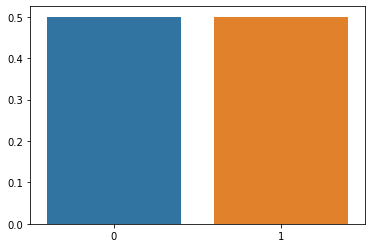

In [55]:
sns.barplot(x=[0,1], y=y_over.value_counts(normalize=True))

In [56]:
from lightgbm import LGBMClassifier

lgbmc = LGBMClassifier()
lgbmc.fit(X_over, y_over.values.ravel())

LGBMClassifier()

In [57]:
lgbm_pred = lgbmc.predict_proba(test)[:, 1]

In [58]:
submit = test_df[['SK_ID_CURR']]
submit['TARGET'] = lgbm_pred

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [59]:
submit.to_csv('lgbm+oversampling.csv', index = False)